# Node identifier: Autoencoder, reconstruction error approach

## Preparation

### Load data

In [1]:
# Import packages
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import networkx as nx
import pickle
#import sys
from sklearn.metrics import *
#import torch.utils.data as data 
import torch
from torch.utils.data import Dataset, DataLoader
# import os
import torch.nn.functional as F
# from tqdm import tqdm
#from torch.optim.lr_scheduler import ReduceLROnPlateau
#from IPython.display import clear_output
#from sklearn import preprocessing
import torch.nn as nn

In [2]:
# Load train and test set
path = 'C:/Users/User/Desktop/Assignatures/Synthesis project/GraphAnomaly/dades_arnau/'

In [4]:
# Use sequential split
with open(path + 'sequential_train.pkl', 'rb') as f:
    train_seq = pickle.load(f)
with open(path + 'sequential_test.pkl', 'rb') as f:
    test_seq = pickle.load(f)

In [5]:
from Helper import split_labels_classes

# Separate data by classes and labels
X_ilicit, y_ilicit, X_licit, y_licit, test_ilicit_X, test_ilicit_y, test_licit_X, test_licit_y = split_labels_classes(train_seq, test_seq)

### Preparate data for the model

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = X        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):        
        return self.X[idx]

In [7]:
# Create dataloaders for each data set
licit_train = CustomDataset(torch.tensor(X_licit.values, dtype=torch.float32))
ilicit_train = CustomDataset(torch.tensor(X_ilicit.values, dtype=torch.float32))
licit_test = CustomDataset(torch.tensor(test_licit_X.values, dtype=torch.float32))
ilicit_test = CustomDataset(torch.tensor(test_ilicit_X.values, dtype=torch.float32)) 

licit_train_loader = DataLoader(licit_train, batch_size=128, shuffle=True)
licit_test_loader = DataLoader(licit_test, batch_size=128, shuffle=False)
ilicit_train_loader = DataLoader(ilicit_train, batch_size=128, shuffle=False)
ilicit_test_loader = DataLoader(ilicit_test, batch_size=128, shuffle=False)

## Autoencoder

### Model definition

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=5):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, 100),
            nn.Tanh(),
            nn.Linear(100, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
def train_ae(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs=10): 
    total_train_loss = [] 
    total_validation_loss = []

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = autoencoder(inputs)
            
            # Compute the loss
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        total_train_loss.append(train_loss)
        
        #validació dins del mateix train loop
        validation_loss = val_ae(autoencoder=autoencoder, data_loader=val_loader, criterion=criterion)
        print(f"Validation Loss: {validation_loss:.4f}")
        total_validation_loss.append(validation_loss)
    return total_train_loss, total_validation_loss

def val_ae(autoencoder, data_loader, criterion):
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in data_loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            val_loss += loss.item()
    epoch_loss = val_loss / len(data_loader.dataset)
    return epoch_loss


### Training 

In [11]:
# Hyperparameters
lr = 0.001
EPOCHS = 60

input_dim = X_licit.shape[1]
model = Autoencoder(input_dim=input_dim,encoding_dim=50)
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

training_loss, validation_loss = train_ae(autoencoder=model, train_loader=licit_train_loader, criterion=criterion, 
                                          optimizer=optimizer, val_loader=licit_test_loader, num_epochs=EPOCHS)
torch.save(model.state_dict(), path + 'ae_rloss.pth')

Epoch [1/60], Training Loss: 2433.6887
Validation Loss: 5.7469
Epoch [2/60], Training Loss: 6.7208
Validation Loss: 2.0369
Epoch [3/60], Training Loss: 2.9396
Validation Loss: 1.0881
Epoch [4/60], Training Loss: 1.7090
Validation Loss: 0.6887
Epoch [5/60], Training Loss: 1.1322
Validation Loss: 0.4799
Epoch [6/60], Training Loss: 0.8089
Validation Loss: 0.3557
Epoch [7/60], Training Loss: 0.6074
Validation Loss: 0.2725
Epoch [8/60], Training Loss: 0.4721
Validation Loss: 0.2169
Epoch [9/60], Training Loss: 0.3768
Validation Loss: 0.1754
Epoch [10/60], Training Loss: 0.3067
Validation Loss: 0.1465
Epoch [11/60], Training Loss: 0.2533
Validation Loss: 0.1224
Epoch [12/60], Training Loss: 0.2123
Validation Loss: 0.1043
Epoch [13/60], Training Loss: 0.1797
Validation Loss: 0.0897
Epoch [14/60], Training Loss: 0.1537
Validation Loss: 0.0770
Epoch [15/60], Training Loss: 0.1321
Validation Loss: 0.0689
Epoch [16/60], Training Loss: 0.1142
Validation Loss: 0.0597
Epoch [17/60], Training Loss: 

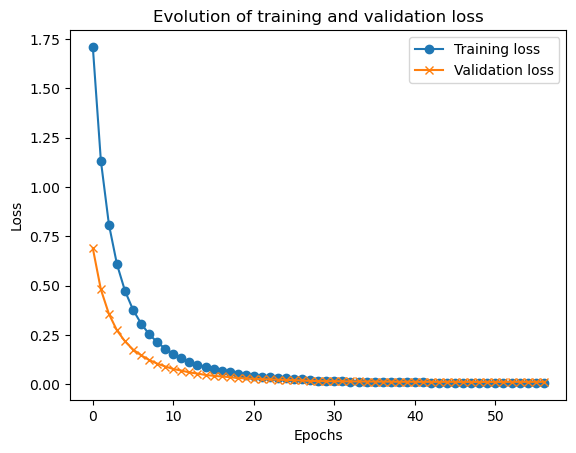

In [14]:
# Sample data: evolution of two lists over time
list1 = training_loss[3:]
list2 = validation_loss[3:]
time_points = range(len(list1))  # Assuming both lists have the same length

# Create a figure and axis
fig, ax = plt.subplots()

# Plot both lists
ax.plot(time_points, list1, label='Training loss', marker='o')
ax.plot(time_points, list2, label='Validation loss', marker='x')

# Add titles and labels
ax.set_title('Evolution of training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Test results

In [260]:
def infer_ae(loader, autoencoder, criterion, msg):
    autoencoder.eval() 
    total_loss = []    
    val_loss = 0.0

    with torch.no_grad():
        for inputs in loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            val_loss += loss.item()
    validation_loss = val_loss / len(loader.dataset)    
    print( msg + str(round(validation_loss,4)))
    total_loss.append(validation_loss)
    return total_loss

In [266]:
# Define the path to the saved model
model_path = path + 'ae_rloss.pth'
# Create an instance of your model
model = Autoencoder(input_dim)
# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()

trainl_rloss = infer_ae(licit_train_loader, model, criterion, 'Train Licit Loss: ')
testl_rloss = infer_ae(licit_test_loader, model, criterion, 'Test Licit Loss: ')
trainil_rloss = infer_ae(ilicit_train_loader, model, criterion, 'Train Ilicit Loss: ')
testil_rloss = infer_ae(ilicit_test_loader, model, criterion, 'Test Ilicit Loss: ')

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([50, 100]) from checkpoint, the shape in current model is torch.Size([5, 100]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([50, 50]) from checkpoint, the shape in current model is torch.Size([5, 5]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([50, 50]) from checkpoint, the shape in current model is torch.Size([5, 5]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([100, 50]) from checkpoint, the shape in current model is torch.Size([100, 5]).

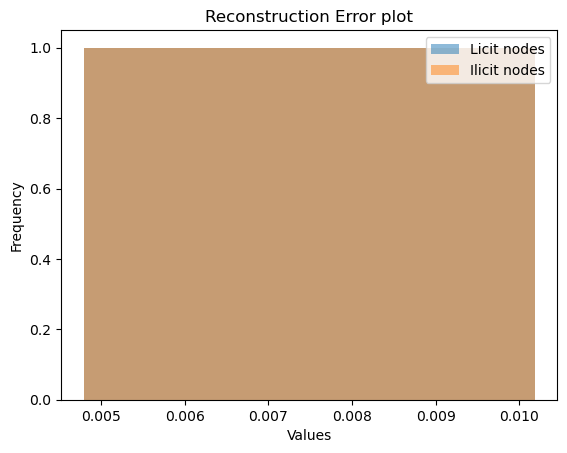

In [221]:
# Determine the range of values in both lists
min_value = min(min(testl_rloss), min(testil_rloss))
max_value = max(max(testl_rloss), max(testil_rloss))

# Plot histograms for both lists with 10 bins
plt.hist(testl_rloss, bins=len(testl_rloss), alpha=0.5, label='Licit nodes', range=(min_value, max_value))
plt.hist(testil_rloss, bins=len(testil_rloss), alpha=0.5, label='Ilicit nodes', range=(min_value, max_value))

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Reconstruction Error plot')

# Add legend
plt.legend()

# Show the plot
plt.show()